# Drawdown Filter Analysis

Analysis of a vectorized drawdown filter applied to monthly contrarian strategy returns.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load equity curve data
data_path = "/Users/edoardocamerinelli/Desktop/momentum_contrarian_unified/approaches/vectorized_contrarian_monthly/data/daily_equity_curve_6m_lookback.csv"
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} data points from {df['Date'].iloc[0]} to {df['Date'].iloc[-1]}")

Loaded 6266 data points from 2000-08-23 to 2025-08-07


## Drawdown Filter Implementation

Vectorized calculation of drawdown filter with 5% threshold. The filter exits positions when drawdown exceeds -5% and re-enters when it recovers.

In [2]:
# Vectorized drawdown filter calculation (no lookahead bias)
equity = df['cumulative_returns'].astype(float).values
eps = 1e-12

# Calculate maximum PREVIOUS value using cummax() shifted
roll_prev = pd.Series(equity).cummax().shift(1).fillna(equity[0]).values
roll_prev = np.where(roll_prev == 0, eps, roll_prev)

# Calculate drawdown relative to previous maximum (vectorized)
drawdown = (equity - roll_prev) / roll_prev

# Apply threshold: exit when drawdown <= -5%
threshold = -0.05
state_at_t = (drawdown > threshold).astype(int)

# Investment state for next period (no lookahead)
state = np.empty_like(state_at_t)
state[0] = 1  # Always invested on first day
state[1:] = state_at_t[:-1]

# Add filter to dataframe
df['invested'] = state

# Summary statistics
exit_points = df.index[(df['invested'].shift(1) == 1) & (df['invested'] == 0)].tolist()
entry_points = df.index[(df['invested'].shift(1) == 0) & (df['invested'] == 1)].tolist()

print(f"Filter applied with {threshold:.1%} threshold")
print(f"Exit points: {len(exit_points)} | Entry points: {len(entry_points)}")
print(f"Time invested: {df['invested'].mean():.1%}")

# Verification (no lookahead check)
roll_prev_check = pd.Series(equity).cummax().shift(1).fillna(equity[0]).values
roll_prev_check = np.where(roll_prev_check == 0, eps, roll_prev_check)
dd_check = (equity - roll_prev_check) / roll_prev_check
state_check_at_t = (dd_check > threshold).astype(int)
state_check = np.empty_like(state_check_at_t)
state_check[0] = 1
state_check[1:] = state_check_at_t[:-1]

mismatch = np.where(state != state_check)[0]
if len(mismatch) == 0:
    print("✓ No lookahead bias detected")
else:
    print(f"⚠ Warning: {len(mismatch)} mismatches detected")

Filter applied with -5.0% threshold
Exit points: 151 | Entry points: 151
Time invested: 25.0%
✓ No lookahead bias detected


## Strategy Comparison

Visual comparison between original and filtered equity curves.

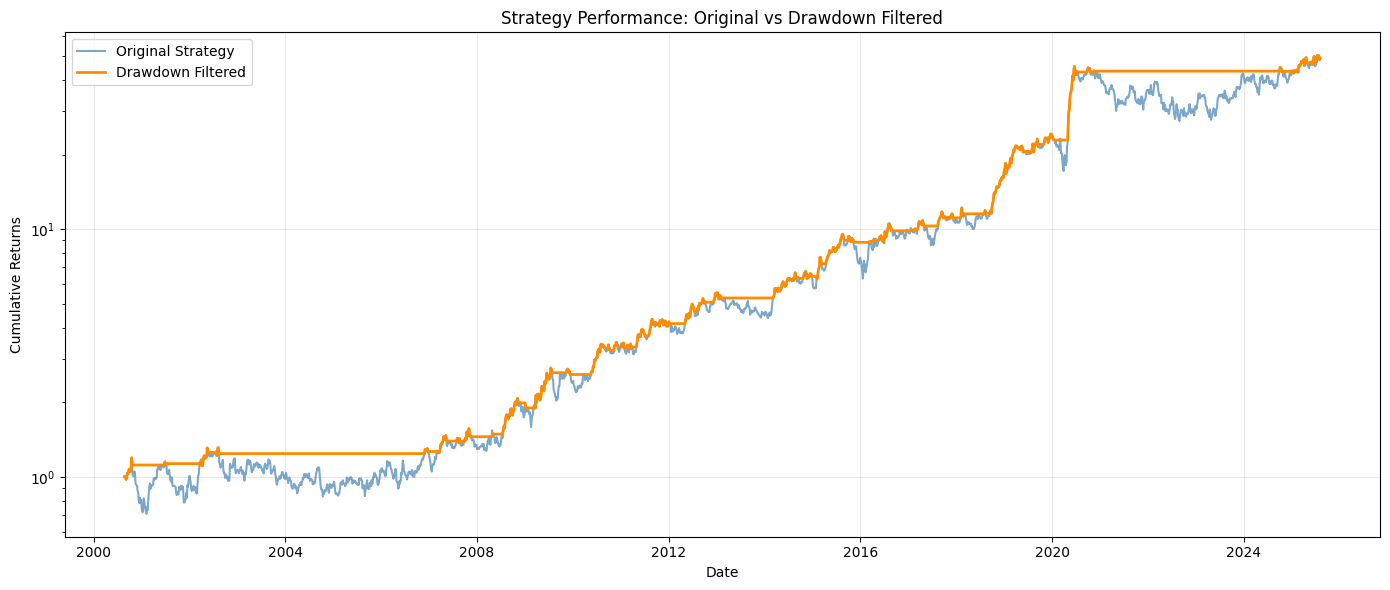

In [3]:
# Prepare data for visualization
if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'])

# Calculate filtered equity curve
filtered_curve = df['cumulative_returns'].copy()
filtered_curve[df['invested'] == 0] = np.nan
filtered_curve = filtered_curve.ffill()

# Optimize plotting for large datasets
step = max(1, len(df) // 2000)

# Create comparison plot
plt.figure(figsize=(14, 6))
plt.plot(df['Date'][::step], df['cumulative_returns'][::step], 
         label='Original Strategy', alpha=0.7, color='steelblue', linewidth=1.5)
plt.plot(df['Date'][::step], filtered_curve[::step], 
         label='Drawdown Filtered', linewidth=2, color='darkorange')

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Performance: Original vs Drawdown Filtered')
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Performance Analysis

Comprehensive performance metrics and rolling statistics for the filtered strategy.

Performance Summary:
------------------------------
Total Return      : 4767.08%
CAGR              :   16.91%
Volatility (Ann.) :   15.34%
Sharpe Ratio      :     1.09
Max Drawdown      :  -10.40%
Years             :    24.86


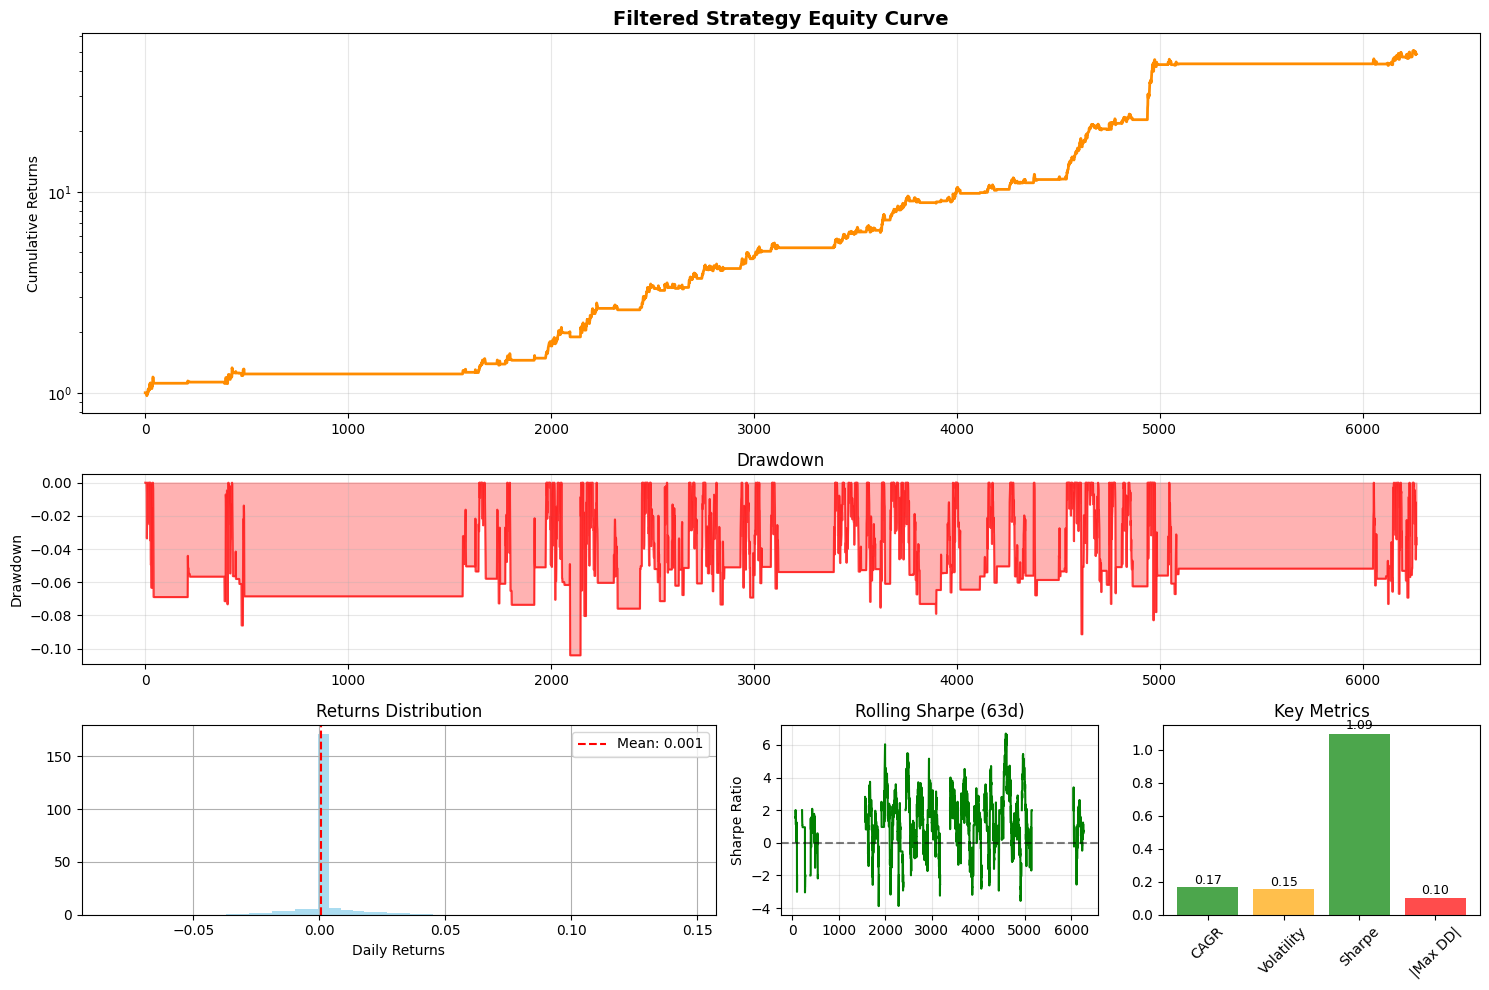

In [4]:
# Performance calculations for filtered strategy
series = filtered_curve.copy()
series = series.astype(float)

# Estimate periods per year from data frequency
periods_per_year = 252  # Default to daily
if isinstance(df['Date'].dtype, object) or np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'])
    diffs = np.diff(df['Date'].values).astype('timedelta64[D]').astype(int)
    median_days = int(np.median(diffs)) if len(diffs) > 0 else 1
    
    if median_days <= 3:
        periods_per_year = 252
    elif 25 <= median_days <= 40:
        periods_per_year = 12
    elif median_days > 40:
        periods_per_year = 4

# Calculate returns and metrics
rets = series.pct_change().dropna()
years = len(rets) / periods_per_year

# Core metrics
total_return = (series.iloc[-1] / series.iloc[0]) - 1
cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else np.nan
ann_vol = rets.std() * np.sqrt(periods_per_year)
sharpe = (rets.mean() * periods_per_year) / ann_vol if ann_vol != 0 else np.nan

# Drawdown calculation
rolling_max = series.cummax()
drawdown = (series - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Rolling metrics
rolling_window = max(2, int(periods_per_year / 4))  # Quarterly rolling
rolling_returns = rets.rolling(rolling_window).apply(lambda x: np.prod(1 + x) - 1, raw=False)
rolling_sharpe = (rets.rolling(rolling_window).mean() * periods_per_year) / (rets.rolling(rolling_window).std() * np.sqrt(periods_per_year))

# Performance summary
performance_stats = {
    'Total Return': total_return,
    'CAGR': cagr,
    'Volatility (Ann.)': ann_vol,
    'Sharpe Ratio': sharpe,
    'Max Drawdown': max_drawdown,
    'Years': years
}

print("Performance Summary:")
print("-" * 30)
for key, value in performance_stats.items():
    if key in ['Total Return', 'CAGR', 'Volatility (Ann.)', 'Max Drawdown']:
        print(f"{key:<18}: {value:>8.2%}")
    else:
        print(f"{key:<18}: {value:>8.2f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[2, 1, 1], width_ratios=[2, 1, 1])

# Main equity curve
ax1 = fig.add_subplot(gs[0, :])
series.plot(ax=ax1, color='darkorange', linewidth=2)
ax1.set_title('Filtered Strategy Equity Curve', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Returns')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Drawdown
ax2 = fig.add_subplot(gs[1, :])
drawdown.plot(ax=ax2, color='red', alpha=0.7)
ax2.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
ax2.set_title('Drawdown', fontsize=12)
ax2.set_ylabel('Drawdown')
ax2.grid(True, alpha=0.3)

# Returns distribution
ax3 = fig.add_subplot(gs[2, 0])
rets.hist(bins=50, ax=ax3, color='skyblue', alpha=0.7, density=True)
ax3.axvline(rets.mean(), color='red', linestyle='--', label=f'Mean: {rets.mean():.3f}')
ax3.set_title('Returns Distribution', fontsize=12)
ax3.set_xlabel('Daily Returns')
ax3.legend()

# Rolling Sharpe
ax4 = fig.add_subplot(gs[2, 1])
rolling_sharpe.plot(ax=ax4, color='green', linewidth=1.5)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title(f'Rolling Sharpe ({rolling_window}d)', fontsize=12)
ax4.set_ylabel('Sharpe Ratio')
ax4.grid(True, alpha=0.3)

# Key metrics bar chart
ax5 = fig.add_subplot(gs[2, 2])
metrics = ['CAGR', 'Volatility', 'Sharpe', '|Max DD|']
values = [cagr, ann_vol, sharpe, abs(max_drawdown)]
colors = ['green' if v > 0 else 'red' for v in [cagr, -ann_vol, sharpe, max_drawdown]]
colors[1] = 'orange'  # Volatility is neutral

bars = ax5.bar(metrics, values, color=colors, alpha=0.7)
ax5.set_title('Key Metrics', fontsize=12)
ax5.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()